# Crypto Analytics Portfolio Project

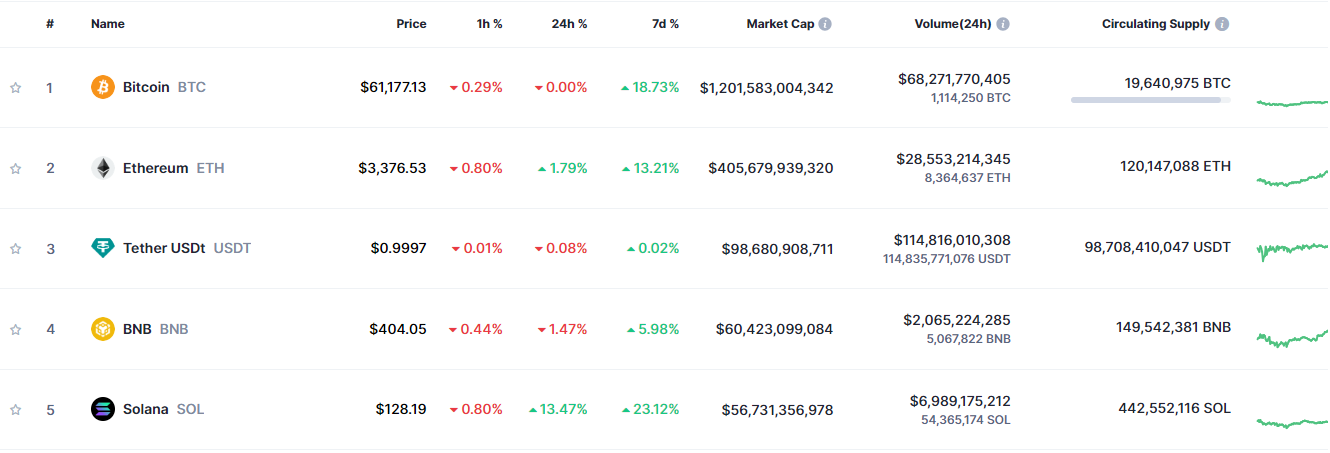

In [1]:
# Importing libraries.

from requests import Session
import json
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import pandas as pd
import os
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# Setting up the API endpoint, request parameters, and headers, including the API key.

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {'start':'1', 'limit':'15', 'convert':'USD'}
headers = {'Accepts': 'application/json', 'X-CMC_PRO_API_KEY': 'b7b79ed8-665a-44d9-ad09-7797797a9463'}

# Initializing a session to perform the API request.

session = Session()
session.headers.update(headers)

# Trying to perform the API request and handling possible errors.

try:
    response = session.get(url, params = parameters)
    data = json.loads(response.text)
    if data['status']['error_code'] == 0:
        print("Data extraction successfully completed.")
    else:
        print(f"Error extracting data (API): {data['status']['error_message']}.")
except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(f"Error extracting data ('requests' module): {e}.")

Data extraction successfully completed.


In [3]:
# Configuring Pandas to display all DataFrame rows/columns and format floating-point numbers globally.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Defining the original DataFrame, adding a time stamp column and displaying it.

df_orig = pd.json_normalize(data['data'])
df_orig['time_stamp'] = pd.to_datetime('now')

df_orig

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,infinite_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,time_stamp
0,1,Bitcoin,BTC,bitcoin,10844,2010-07-13T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...","21,000,000.00","19,642,818.00","19,642,818.00",False,NaN,1,NaN,NaN,None,2024-03-02T19:12:00.000Z,"62,096.65","28,471,948,602.73",-34.72,0.30,-0.10,20.60,44.73,37.54,57.04,"1,219,753,277,622.59",52.09,"1,304,029,739,015.77",None,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
1,1027,Ethereum,ETH,ethereum,8486,2015-08-07T00:00:00.000Z,"[pos, smart-contracts, ethereum-ecosystem, coi...",NaN,"120,138,874.31","120,138,874.31",True,NaN,2,NaN,NaN,None,2024-03-02T19:12:00.000Z,"3,431.56","12,732,654,261.07",-33.52,0.25,0.15,15.01,49.39,44.76,58.62,"412,263,216,440.93",17.60,"412,263,216,440.93",None,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
2,825,Tether USDt,USDT,tether,76681,2015-02-25T00:00:00.000Z,"[payments, stablecoin, asset-backed-stablecoin...",NaN,"99,179,337,470.69","101,600,078,701.91",True,NaN,3,NaN,NaN,None,2024-03-02T19:11:00.000Z,1.00,"72,302,986,634.55",-9.61,0.01,0.07,0.13,0.14,0.07,0.08,"99,289,922,553.15",4.24,"101,713,362,913.81",None,2024-03-02T19:11:00.000Z,"1,027.00",Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2024-03-02 16:13:22.105439
3,1839,BNB,BNB,bnb,2081,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",NaN,"149,541,957.82","149,541,957.82",False,NaN,4,NaN,NaN,None,2024-03-02T19:11:00.000Z,409.31,"1,550,641,997.27",-3.46,0.20,0.63,7.11,36.39,31.94,80.37,"61,209,126,173.74",2.61,"61,209,126,173.74",None,2024-03-02T19:11:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
4,5426,Solana,SOL,solana,628,2020-04-10T00:00:00.000Z,"[pos, platform, solana-ecosystem, cms-holdings...",NaN,"442,824,138.45","570,876,458.64",True,NaN,5,NaN,NaN,None,2024-03-02T19:12:00.000Z,129.99,"3,042,554,261.02",-39.70,1.28,-1.93,25.62,34.17,19.51,107.83,"57,562,316,416.32",2.46,"74,207,723,774.83",None,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
5,52,XRP,XRP,xrp,1237,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, arr...","100,000,000,000.00","54,664,031,281.00","99,987,852,435.00",False,NaN,6,NaN,NaN,None,2024-03-02T19:12:00.000Z,0.63,"2,948,173,238.47",50.40,0.83,6.52,16.20,25.01,1.30,2.38,"34,682,847,523.96",1.48,"63,447,291,959.99",None,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
6,3408,USDC,USDC,usd-coin,16976,2018-10-08T00:00:00.000Z,"[medium-of-exchange, stablecoin, asset-backed-...",NaN,"29,021,805,557.11","29,021,805,557.11",False,NaN,7,NaN,NaN,None,2024-03-02T19:12:00.000Z,1.00,"6,406,354,977.06",-18.53,-0.00,-0.01,-0.01,-0.04,-0.02,-0.01,"29,017,919,617.50",1.24,"29,017,919,617.50",None,2024-03-02T19:12:00.000Z,"1,027.00",Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2024-03-02 16:13:22.105439
7,2010,Cardano,ADA,cardano,1085,2017-10-01T00:00:00.000Z,"[dpos, pos, platform, research, smart-contract...","45,000,000,000.00","35,479,773,841.02","36,671,429,496.45",False,NaN,8,NaN,NaN,None,2024-03-02T19:11:00.000Z,0.74,"1,311,077,741.51",39.05,1.17,6.94,25.45,49.88,20.49,90.63,"26,345,079,675.21",1.13,"33,414,209,196.96",None,2024-03-02T19:11:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:22.105439
8,74,Dogecoin,DOGE,dogecoin,899,2013-12-15T00:00:00.000Z,"[mineable, pow, scrypt

In [4]:
# Combining the above to define a function that makes the API request and leaves the data in the original DataFrame.
# Also, it creates a CSV file and adds the data from each request there.
# If the file already exists, it just adds the data.

def api_runner(x):
    global df_orig
    
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {'start':'1', 'limit':'15', 'convert':'USD'}
    headers = {'Accepts': 'application/json', 'X-CMC_PRO_API_KEY': 'b7b79ed8-665a-44d9-ad09-7797797a9463'}
    
    session = Session()
    session.headers.update(headers)
    
    try:
        response = session.get(url, params = parameters)
        data = json.loads(response.text)
        if data['status']['error_code'] == 0:
            print(f"Attempt {x + 1}: Data extraction successfully completed.")
            
            df_orig = pd.json_normalize(data['data'])
            df_orig['time_stamp'] = pd.to_datetime('now')
    
            if not os.path.isfile('Crypto Data.csv'):
                df_orig.to_csv('Crypto Data.csv', index = False)
            else:
                df_orig.to_csv('Crypto Data.csv', mode = 'a', header = False, index = False)
        else:
            print(f"Attempt {x + 1}: Error extracting data (API): {data['status']['error_message']}.")
    except (ConnectionError, Timeout, TooManyRedirects) as e:
            print(f"Attempt {x + 1}: Error extracting data ('requests' module): {e}.")

In [5]:
# Defining a for loop that executes an API request once per minute, repeating this process a total of 10 times.

for i in range(10):
    if i < 9:
        api_runner(i)
        time.sleep(60)
    else:
        api_runner(i)

Attempt 1: Data extraction successfully completed.
Attempt 2: Data extraction successfully completed.
Attempt 3: Data extraction successfully completed.
Attempt 4: Data extraction successfully completed.
Attempt 5: Data extraction successfully completed.
Attempt 6: Data extraction successfully completed.
Attempt 7: Data extraction successfully completed.
Attempt 8: Data extraction successfully completed.
Attempt 9: Data extraction successfully completed.
Attempt 10: Data extraction successfully completed.


In [6]:
# Defining the original DataFrame with the data from the created file and displaying it.

df_orig = pd.read_csv('Crypto Data.csv')

df_orig

,id,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,infinite_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,tvl_ratio,last_updated,quote.USD.price,quote.USD.volume_24h,quote.USD.volume_change_24h,quote.USD.percent_change_1h,quote.USD.percent_change_24h,quote.USD.percent_change_7d,quote.USD.percent_change_30d,quote.USD.percent_change_60d,quote.USD.percent_change_90d,quote.USD.market_cap,quote.USD.market_cap_dominance,quote.USD.fully_diluted_market_cap,quote.USD.tvl,quote.USD.last_updated,platform.id,platform.name,platform.symbol,platform.slug,platform.token_address,time_stamp
0,1,Bitcoin,BTC,bitcoin,10844,2010-07-13T00:00:00.000Z,"['mineable', 'pow', 'sha-256', 'store-of-value...","21,000,000.00","19,642,818.00","19,642,818.00",False,NaN,1,NaN,NaN,NaN,2024-03-02T19:12:00.000Z,"62,096.65","28,471,948,602.73",-34.72,0.30,-0.10,20.60,44.73,37.54,57.04,"1,219,753,277,622.59",52.09,"1,304,029,739,015.77",NaN,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
1,1027,Ethereum,ETH,ethereum,8486,2015-08-07T00:00:00.000Z,"['pos', 'smart-contracts', 'ethereum-ecosystem...",NaN,"120,138,874.31","120,138,874.31",True,NaN,2,NaN,NaN,NaN,2024-03-02T19:12:00.000Z,"3,431.56","12,732,654,261.07",-33.52,0.25,0.15,15.01,49.39,44.76,58.62,"412,263,216,440.93",17.60,"412,263,216,440.93",NaN,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
2,825,Tether USDt,USDT,tether,76681,2015-02-25T00:00:00.000Z,"['payments', 'stablecoin', 'asset-backed-stabl...",NaN,"99,179,337,470.69","101,600,078,701.91",True,NaN,3,NaN,NaN,NaN,2024-03-02T19:11:00.000Z,1.00,"72,302,986,634.55",-9.61,0.01,0.07,0.13,0.14,0.07,0.08,"99,289,922,553.15",4.24,"101,713,362,913.81",NaN,2024-03-02T19:11:00.000Z,"1,027.00",Ethereum,ETH,ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,2024-03-02 16:13:23.258072
3,1839,BNB,BNB,bnb,2081,2017-07-25T00:00:00.000Z,"['marketplace', 'centralized-exchange', 'payme...",NaN,"149,541,957.82","149,541,957.82",False,NaN,4,NaN,NaN,NaN,2024-03-02T19:11:00.000Z,409.31,"1,550,641,997.27",-3.46,0.20,0.63,7.11,36.39,31.94,80.37,"61,209,126,173.74",2.61,"61,209,126,173.74",NaN,2024-03-02T19:11:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
4,5426,Solana,SOL,solana,628,2020-04-10T00:00:00.000Z,"['pos', 'platform', 'solana-ecosystem', 'cms-h...",NaN,"442,824,138.45","570,876,458.64",True,NaN,5,NaN,NaN,NaN,2024-03-02T19:12:00.000Z,129.99,"3,042,554,261.02",-39.70,1.28,-1.93,25.62,34.17,19.51,107.83,"57,562,316,416.32",2.46,"74,207,723,774.83",NaN,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
5,52,XRP,XRP,xrp,1237,2013-08-04T00:00:00.000Z,"['medium-of-exchange', 'enterprise-solutions',...","100,000,000,000.00","54,664,031,281.00","99,987,852,435.00",False,NaN,6,NaN,NaN,NaN,2024-03-02T19:12:00.000Z,0.63,"2,948,173,238.47",50.40,0.83,6.52,16.20,25.01,1.30,2.38,"34,682,847,523.96",1.48,"63,447,291,959.99",NaN,2024-03-02T19:12:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
6,3408,USDC,USDC,usd-coin,16976,2018-10-08T00:00:00.000Z,"['medium-of-exchange', 'stablecoin', 'asset-ba...",NaN,"29,021,805,557.11","29,021,805,557.11",False,NaN,7,NaN,NaN,NaN,2024-03-02T19:12:00.000Z,1.00,"6,406,354,977.06",-18.53,-0.00,-0.01,-0.01,-0.04,-0.02,-0.01,"29,017,919,617.50",1.24,"29,017,919,617.50",NaN,2024-03-02T19:12:00.000Z,"1,027.00",Ethereum,ETH,ethereum,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2024-03-02 16:13:23.258072
7,2010,Cardano,ADA,cardano,1085,2017-10-01T00:00:00.000Z,"['dpos', 'pos', 'platform', 'research', 'smart...","45,000,000,000.00","35,479,773,841.02","36,671,429,496.45",False,NaN,8,NaN,NaN,NaN,2024-03-02T19:11:00.000Z,0.74,"1,311,077,741.51",39.05,1.17,6.94,25.45,49.88,20.49,90.63,"26,345,079,675.21",1.13,"33,414,209,196.96",NaN,2024-03-02T19:11:00.000Z,NaN,NaN,NaN,NaN,NaN,2024-03-02 16:13:23.258072
8,74,Dogecoin,DOGE,dogecoin,899,2013-12-15T00:00:00.000Z,"['mineable', 'pow', 'scrypt', 'medium-

# DataFrame 1

In [7]:
# Creating DataFrame 1.
# The goal is to show the average percentage change for each cryptocurrency across specified time frames.
# For instance, if the cryptocurrency is Bitcoin and the time frame is 1 hour,
# the third column will present the average percentage change for Bitcoin over all 1-hour intervals.

# Creating a list that has the columns that include 'percent' in its name.

percent_columns = [col for col in df_orig.columns if 'percent' in col]

# Defining DataFrame 1 by making transformations to the original.
# A filter is applied with 'percent_columns' (defined above) to obtain the desired columns.

df1 = df_orig.groupby('name', sort = False)[percent_columns].mean().stack().to_frame().reset_index()

# Changing the column names.

df1.columns = ['Cryptocurrency', 'Time Frame', 'Avg. Percent Change']

# Modifying the data in the 'Time Frame' column.

df1['Time Frame'] = df1['Time Frame'].str.split(pat = '_').str[-1]

# Displaying DataFrame 1.

df1

,Cryptocurrency,Time Frame,Avg. Percent Change
0,Bitcoin,1h,0.21
1,Bitcoin,24h,-0.13
2,Bitcoin,7d,20.53
3,Bitcoin,30d,44.80
4,Bitcoin,60d,37.51
5,Bitcoin,90d,57.12
6,Ethereum,1h,0.13
7,Ethereum,24h,0.06
8,Ethereum,7d,14.94
9,Ethereum,30d,49.37


In [8]:
# Suppressing UserWarning messages to ensure a clean output.

warnings.filterwarnings('ignore', category = UserWarning)

# Setting seaborn theme to 'darkgrid'.

sns.set_theme(style = 'darkgrid')

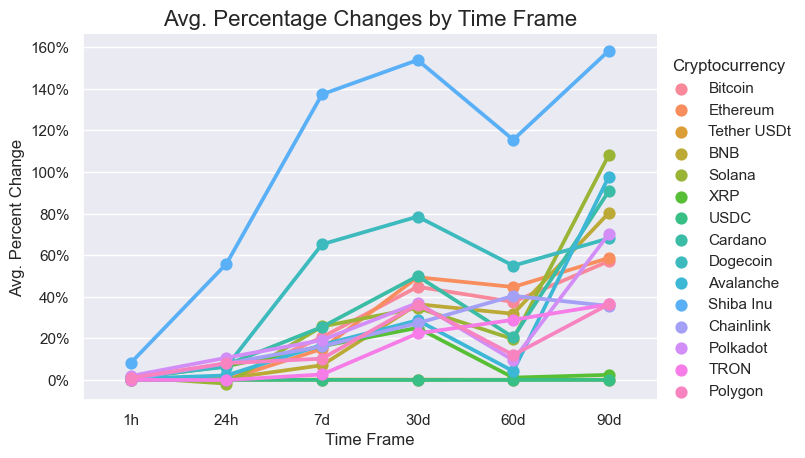

In [9]:
# Generating a point plot to visualize the data from DataFrame 1.
# The data is differentiated for each type of cryptocurrency and the dimensions are adjusted.

sns.catplot(x = 'Time Frame', y = 'Avg. Percent Change', hue = 'Cryptocurrency', data = df1, kind = 'point', height = 4.5, aspect = 1.5)

# Adding a title.

plt.title('Avg. Percentage Changes by Time Frame', fontsize = 16)

# Retrieving the current axes for further customization.

ax = plt.gca()

# Defining a function to change the format of the y-axis values and applying it.

def number_formatter(y, pos):
    return '{:,.0f}%'.format(y)

ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Displaying the plot.

plt.show()

# DataFrame 2

In [10]:
# Creating DataFrame 2.
# The idea is to filter the Bitcoin cryptocurrency with its price and time stamp.
# This way the price change over time can be seen.

# Defining DataFrame 2 by making transformations to the original.
# The intention is to filter out everything to do with Bitcoin and extract the desired columns.

df2 = df_orig.query("name == 'Bitcoin'").reset_index()[['name', 'quote.USD.price', 'time_stamp']]

# Changing the column names.

df2.columns = ['Cryptocurrency', 'Price', 'Time Stamp']

# Changing the data format in the 'Time Stamp' column.
# This will be useful for readability when displaying the plot.

df2['Time Stamp'] = pd.to_datetime(df2['Time Stamp'])
df2['Time Stamp'] = df2['Time Stamp'].dt.strftime('%Y-%m-%d\n%H:%M:%S')

# Displaying DataFrame 2.

df2

,Cryptocurrency,Price,Time Stamp
0,Bitcoin,"62,096.65",2024-03-02\n16:13:23
1,Bitcoin,"62,091.45",2024-03-02\n16:14:24
2,Bitcoin,"62,055.24",2024-03-02\n16:15:25
3,Bitcoin,"62,055.62",2024-03-02\n16:16:26
4,Bitcoin,"62,098.02",2024-03-02\n16:17:26
5,Bitcoin,"62,086.44",2024-03-02\n16:18:28
6,Bitcoin,"62,097.45",2024-03-02\n16:19:28
7,Bitcoin,"62,097.88",2024-03-02\n16:20:29
8,Bitcoin,"62,084.30",2024-03-02\n16:21:30
9,Bitcoin,"62,068.10",2024-03-02\n16:22:31


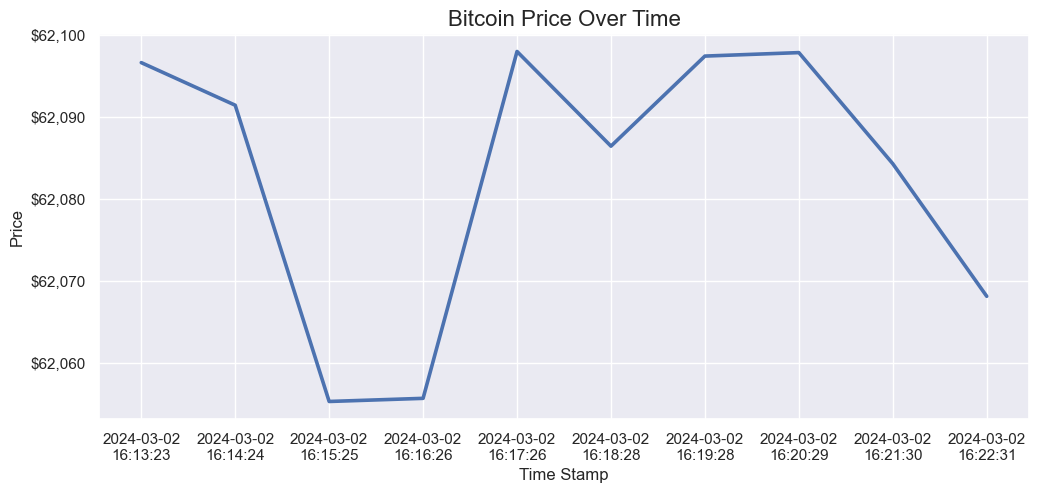

In [11]:
# Setting the size of the next figure.

plt.figure(figsize = (12, 5))

# Generating a line plot to visualize the data from DataFrame 2.
# The line width is also modified.

sns.lineplot(x = 'Time Stamp', y = 'Price', data = df2, linewidth = 2.6)

# Adding a title.

plt.title('Bitcoin Price Over Time', fontsize = 16)

# Retrieving the current axes for further customization.

ax = plt.gca()

# Defining a function to change the format of the y-axis values and applying it.

def number_formatter(y, pos):
    return '${:,.0f}'.format(y)

ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Displaying the plot.

plt.show()

# DataFrame 3

In [12]:
# Creating DataFrame 3.
# The aim is to see the current market capitalization of each cryptocurrency ordered from highest to lowest.

# Obtaining the last time stamp recorded.

time_stamp_max = df_orig['time_stamp'].max()

# Defining DataFrame 3 by making transformations to the original.
# Rows where the column 'time_stamp' matches 'time_stamp_max' (defined above) are filtered out.
# The desired columns are extracted.

df3 = df_orig[df_orig['time_stamp'] == time_stamp_max].reset_index()[['name','quote.USD.market_cap']]

# Changing the column names.

df3.columns = ['Cryptocurrency', 'Market Capitalization']

# Displaying DataFrame 3.

df3

,Cryptocurrency,Market Capitalization
0,Bitcoin,"1,219,192,328,945.12"
1,Ethereum,"411,907,457,595.43"
2,Tether USDt,"99,274,791,775.38"
3,BNB,"61,192,535,651.48"
4,Solana,"57,692,895,744.64"
5,XRP,"34,667,342,051.04"
6,USDC,"29,018,440,942.89"
7,Cardano,"26,357,648,074.43"
8,Dogecoin,"20,280,621,408.47"
9,Avalanche,"16,197,876,856.78"


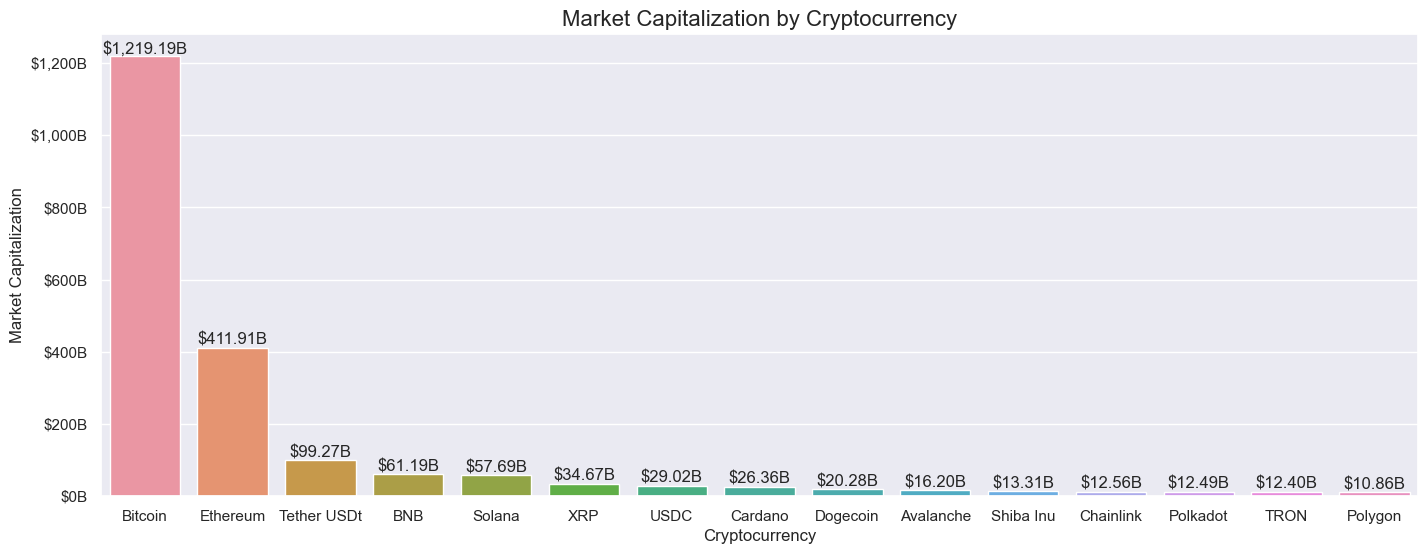

In [13]:
# Setting the size of the next figure.

plt.figure(figsize = (17, 6))

# Generating a bar plot to visualize the data from DataFrame 3.

sns.barplot(x = 'Cryptocurrency', y = 'Market Capitalization', data = df3)

# Adding a title.

plt.title('Market Capitalization by Cryptocurrency', fontsize = 16)

# Retrieving the current axes for further customization.

ax = plt.gca()

# Defining a function to change the format of the y-axis values and applying it.

def number_formatter(y, pos):
    return '${:,.0f}B'.format(y*1e-9)

ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Defining a for loop that iterates over the bars of the plot to add a label on each one.
# To do this, it calculates the label position and formats the bar height (value) in millions ('M').
# Then it places the label in the plot.

for bar in ax.patches:
    height = bar.get_height()
    bar_center = bar.get_x() + bar.get_width() / 2
    label = '${:,.2f}B'.format(height*1e-9)
    
    ax.text(bar_center, height, label, ha = 'center', va = 'bottom')